# Lineage Tracking for Cells in the Mother Machine

In [1]:
from LineageTrack.lineage_tracker import LineageTrack
from IPython.display import display, HTML
import numpy as np

### comment out ###
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')

### Data Preparation
Load the properties of cells from a directory containing the csv files **only** or load it with paths to every single file

The cell properties data can be obtained from `skimage.measure.regionprops` on the masked trench images

In [2]:
directory = ".\\example\\"    # the example includes the first 13 trenches from Charlie's Phage experiment
exp = LineageTrack(directory)
print(exp)
display(exp.df.head(1))
# or
# filepath1 = ""
# filepath2 = ""
# ...
# exp = LineageTrack(filepath1, filepath2, ...)

Looking for data at these locations:
.\example\2022_04_22_PC_data_epoch_20_prob_99.csv
.\example\2022_04_22_RFP_data_epoch_20_prob_99.csv
.\example\2022_04_22_YFP_data_epoch_20_prob_99.csv
Finished loading the data
(11859, 13)

            Read 3 files
            Channels: ['PC', 'YFP', 'mCherry']
            Properties for each cell: ['PC_intensity_mean', 'YFP_intensity_mean', 'area', 'centroid-0', 'centroid-1', 'centroid_local-0', 'centroid_local-1', 'label', 'mCherry_intensity_mean', 'major_axis_length', 'minor_axis_length', 'time_(mins)', 'trench_id']
        


,trench_id,time_(mins),label,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,centroid_local-0,centroid_local-1,PC_intensity_mean,mCherry_intensity_mean,YFP_intensity_mean
0,0,0,1,238,53.914722,7.221878,94.672272,65.420166,23.67227,4.420168,2048.146973,2647.348633,148.050415


### Tracking Algorithm: Strategy 3 on the Log Book

*Currently this algorithm is designed for exponential growth*

Model for cell growing: $L_{t+\Delta t} = L_t \times 2^{(\Delta t / \tau)}$

Model for one cell dividing during a time interval, Δt (very simplified and has big assumption): 
- Poisson distribution, $Pr(k) = \frac{\lambda^k}{k!}e^{-\lambda}$
- $\lambda = \Delta t/T $
- Pr(divide) = Pr(k=1)
- Pr(no divide) = Pr(k=0)
- Assumptions: Division of a cell is independent of the previous division of the cell and its length; Division between cells are independent

#### STEP 1:
Estimate the growth time constant $\tau$, or the doubling time T, by observing the mother cell in some trenches (they can be the same thing but are measured in different ways here)

User need to select the exponential growth period

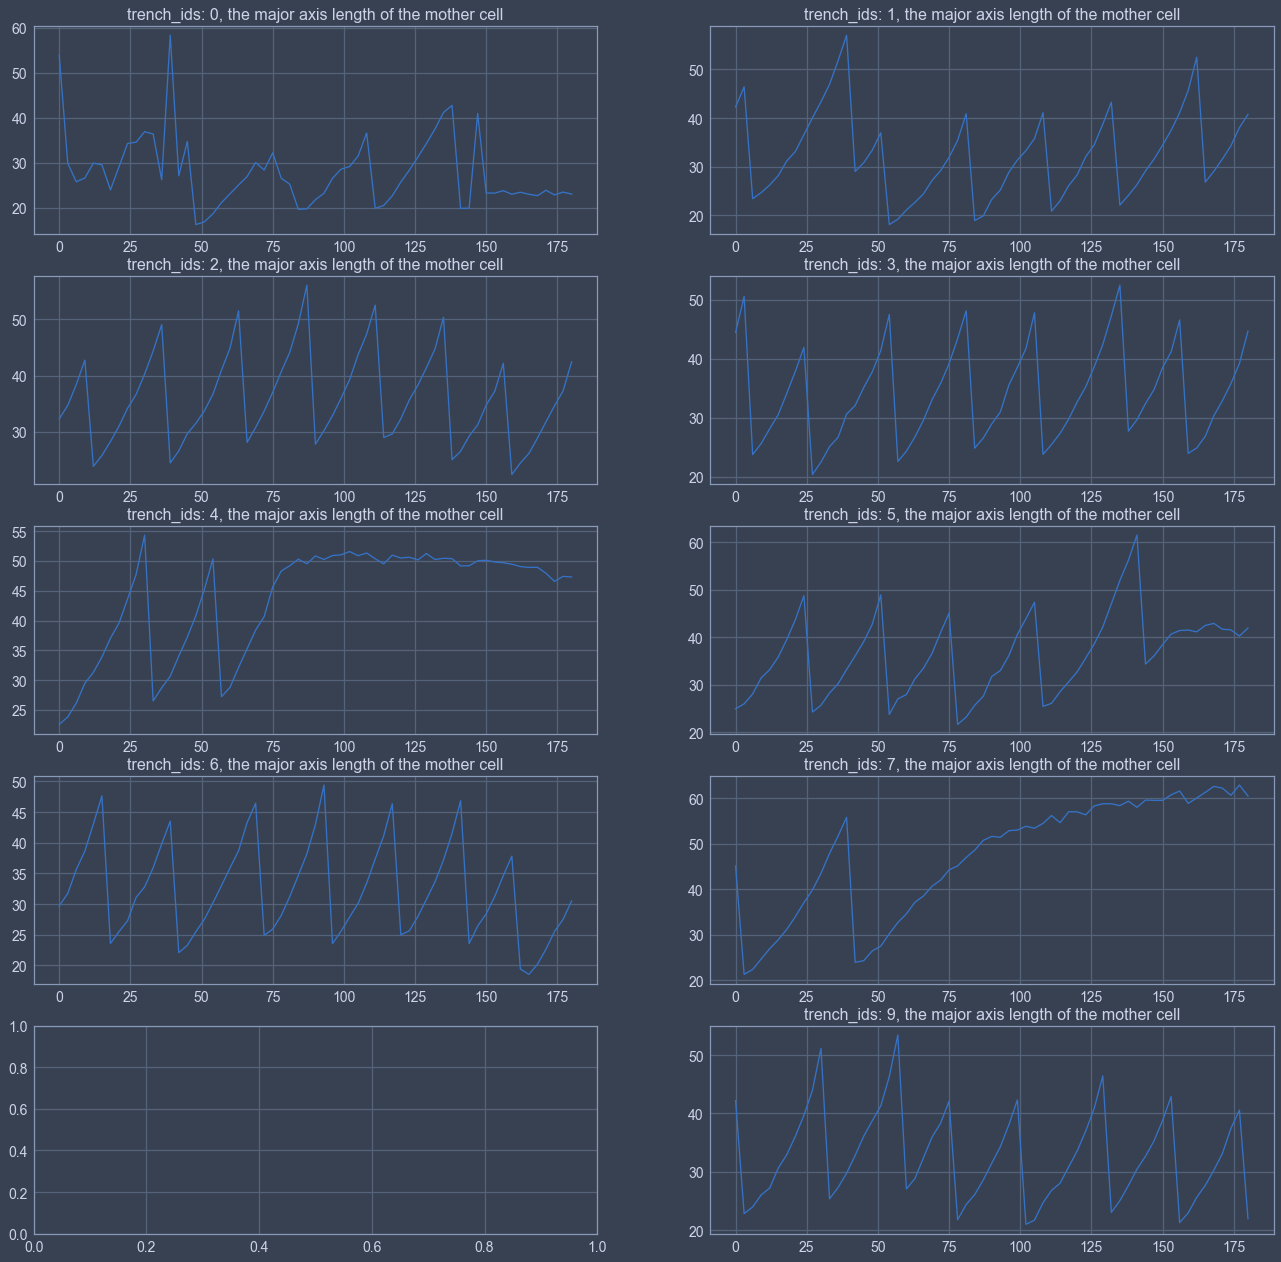

In [3]:
trench_list = [i for i in range(10)]

m = exp.get_mother_cell_growth(trench_list, plot=True)

Find the division times for trench 1

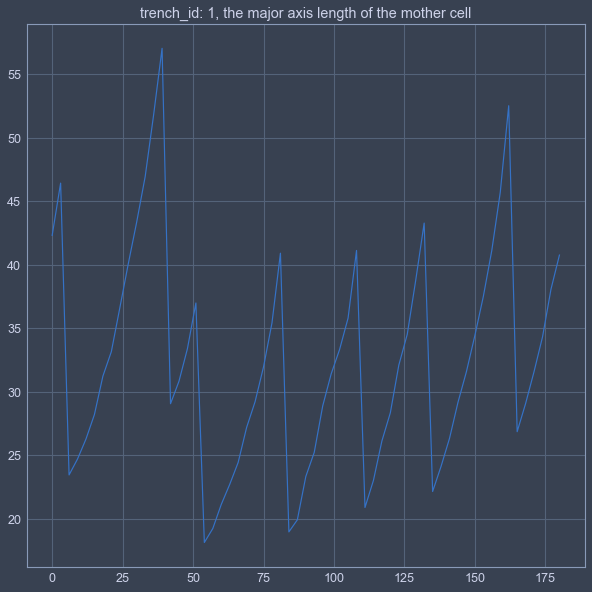

[[  3.          46.41300583]
 [ 39.          57.02418137]
 [ 51.          36.97775269]
 [ 81.          40.89678574]
 [108.          41.11452484]
 [132.          43.26797485]
 [162.          52.50556564]]


In [4]:
mcell1, idx1 = exp.find_division(1)

peaks = [mcell1[1][i, :] for i in idx1]
peaks = np.array(peaks)
print(peaks)

Select the peaks between the exponential growth phase, calculate intervals between division and for each interval, estimate the growth constant

[36.0, 12.0, 30.0, 27.0, 24.0, 30.0]
the slope is estimated to be 0.038872735918546425
the intercept is estimated to be 4.501272528268139


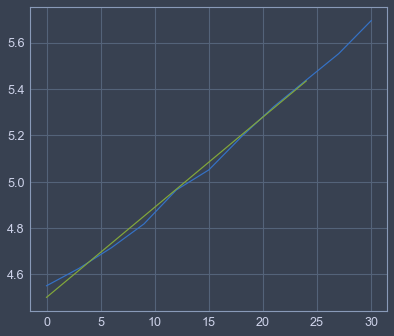

the slope is estimated to be 0.033439747875788996
the intercept is estimated to be 4.855506304192734


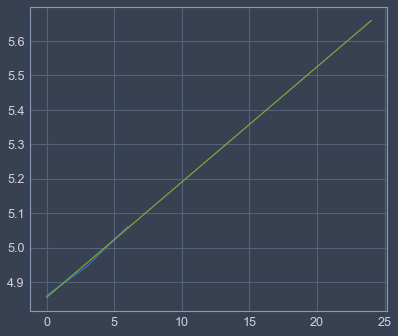

the slope is estimated to be 0.04031699186300881
the intercept is estimated to be 4.153692489401551


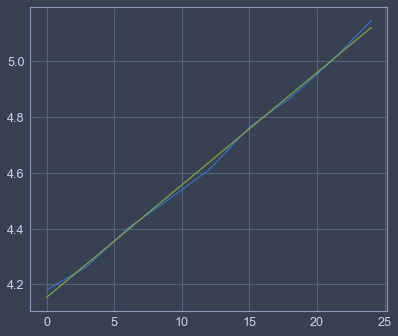

the slope is estimated to be 0.04608023245107278
the intercept is estimated to be 4.2417947414170545


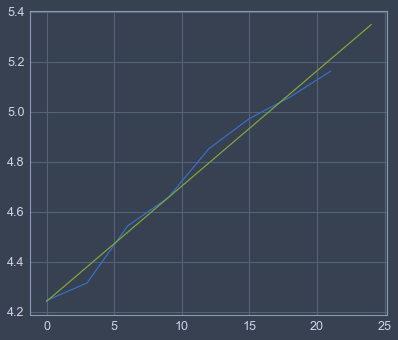

the slope is estimated to be 0.0493229777528664
the intercept is estimated to be 4.388885019014377


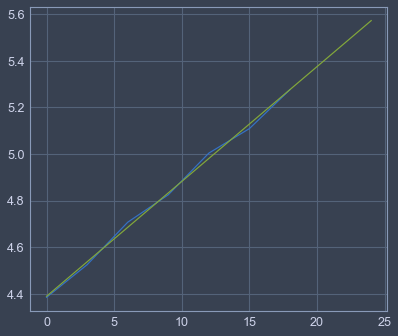

the slope is estimated to be 0.04304354489620594
the intercept is estimated to be 4.465180328222813


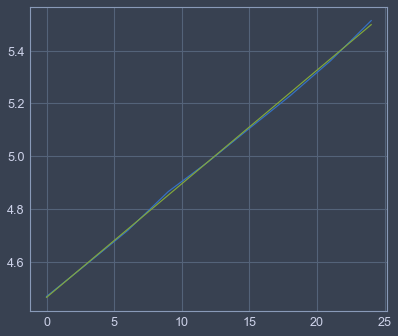

[36.0, 12.0, 30.0, 27.0, 24.0, 30.0]
[0.038872735918546425, 0.033439747875788996, 0.04031699186300881, 0.04608023245107278, 0.0493229777528664, 0.04304354489620594]


In [5]:
# slice it according to the data
# in this case data between every peaks can be used
e_phase_idx1 = idx1[:]

exp.collect_model_para(mcell1, e_phase_idx1, plot=True)
print(exp.div_intervals)
print(exp.growth_taus)

Repeat for trench 2, and so on

In [6]:
# mcell2, idx2 = exp.find_division(2)

In [7]:
# exp.collect_model_para(mcell2, idx2[:])

In [8]:
# mcell3, idx3 = exp.find_division(3)
# mcell3, idx3 = exp.find_division(4)
# mcell5, idx5 = exp.find_division(5)

In [9]:
# exp.collect_model_para(mcell3, idx3[:])
# slice it according to the data
# e_phase_idx4 = idx4[:-1]    # do not use the last peak

# exp.collect_model_para(mcell4, e_phase_idx4)
# exp.collect_model_para(mcell4, e_phase_idx4) # this shows collect_model_para only need to be run once for each mother cell
# exp.collect_model_para(mcell5, idx5[:])

In [10]:
exp.update_model_para()


                The average time interval for division is 26.5
                The time constant for exponential growth is 23.897124717454066


For some cases where you might want to set the parameters manually, they are:

`self.div_interval` = 24 - used for setting up prior probability

or, 

`self.growth_tau` = 24 - used for estimating the growth of the cells length

#### STEP 2:
For each frame in each trench, look at the current frame in the trench and predict a list of furture of the cells in the next frame with some probability (prior) by using the model from above: growth and division. 

Score each furture with a likelihood function. Select the one with the highest value of prior x likelihood. 

Can square the likelihood to diminish the effect of prior since the prior has not considered the dependence between divisions. 

**Interested cell's properties**
- Label: only consider the several cells at the top of the trench, the order is consistent
- Major axis length: relevant to cell growth, cell division
- Centroid y coordinates: relevant to cell growth and also the growth of all the previous cells

Since they are geometrical properties, I have decided to not normalise the features.

Run `track_trench` for specified trench, this function can have the following arguments:
- `trench` is the trench_id the track the cells
- `threshold` is the limit of the centroid y axis - this is to limit the number of cells to look at in each trench
- `max_dpf` is the maximum division per frame to simulate, 1 or 2 should be enough but in principle this value can go up to the total number of cells below the threshold, i.e. all cells divide.
- `mode` is to select the method used to search the cells' matching future, options are simple nearest neighbour 'KDTree' or sequence matching 'SeqMatch' (exclusively one-to-one matching, suggested)

In [11]:
exp.track_trench(trench=1, threshold=250, max_dpf=1)

looking at cells: 
cell in trench 1.0 at 0.0 min with label 1.0
cell in trench 1.0 at 0.0 min with label 2.0
cell in trench 1.0 at 0.0 min with label 3.0
cell in trench 1.0 at 0.0 min with label 4.0
cell in trench 1.0 at 0.0 min with label 5.0
RESULT:
8.47768994339519e-05
['Growing', 'Growing', 'Growing', 'Growing', 'Growing']


looking at cells: 
cell in trench 1.0 at 3.0 min with label 1.0
cell in trench 1.0 at 3.0 min with label 2.0
cell in trench 1.0 at 3.0 min with label 3.0
cell in trench 1.0 at 3.0 min with label 4.0
cell in trench 1.0 at 3.0 min with label 5.0
RESULT:
0.00024935412828165426
['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']


looking at cells: 
cell in trench 1.0 at 6.0 min with label 1.0
cell in trench 1.0 at 6.0 min with label 2.0
cell in trench 1.0 at 6.0 min with label 3.0
cell in trench 1.0 at 6.0 min with label 4.0
cell in trench 1.0 at 6.0 min with label 5.0
RESULT:
0.0005311185307927904
['Growing', 'Growing', 'Growing', 'Growing', 'Growing']


loo

looking at cells: 
cell in trench 1.0 at 105.0 min with label 1.0
cell in trench 1.0 at 105.0 min with label 2.0
cell in trench 1.0 at 105.0 min with label 3.0
RESULT:
4.191382287919821e-05
['Growing', 'Growing', 'Divided!']


looking at cells: 
cell in trench 1.0 at 108.0 min with label 1.0
cell in trench 1.0 at 108.0 min with label 2.0
cell in trench 1.0 at 108.0 min with label 3.0
cell in trench 1.0 at 108.0 min with label 4.0
cell in trench 1.0 at 108.0 min with label 5.0
RESULT:
7.004323871138587e-05
['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']


looking at cells: 
cell in trench 1.0 at 111.0 min with label 1.0
cell in trench 1.0 at 111.0 min with label 2.0
cell in trench 1.0 at 111.0 min with label 3.0
cell in trench 1.0 at 111.0 min with label 4.0
cell in trench 1.0 at 111.0 min with label 5.0
RESULT:
3.427251653858483e-05
['Divided!', 'Growing', 'Growing', 'Growing', 'Growing']


looking at cells: 
cell in trench 1.0 at 114.0 min with label 1.0
cell in trench 1.0 at

#### Results:
The results are stored as a new set of Pandas DataFrame, containing all the cells that are below the threshold specified earlier. The colume parent_label shows the label of this cell in the previous frame. 

None means they are not matched. 

There is also a new DataFrame containing all the cells that is considered to be lysed or pushed out of the interested area of the trench, i.e., not matched in the algorithm.

In [12]:

display(HTML(exp.track_df.to_html()))
display(HTML(exp.lysis_df.to_html()))

,trench_id,time_(mins),label,parent_label
0,1,3,1.0,1.0
1,1,3,2.0,2.0
2,1,3,3.0,3.0
3,1,3,4.0,4.0
4,1,3,5.0,5.0
5,1,6,1.0,1.0
6,1,6,2.0,1.0
7,1,6,3.0,2.0
8,1,6,4.0,3.0
9,1,6,5.0,4.0


,trench_id,time_(mins),label
0,1,3,5
1,1,15,5
2,1,36,2
3,1,48,5
4,1,54,6
5,1,66,5
6,1,75,5
7,1,87,6
8,1,93,2
9,1,102,4
